# Классификация текстов с использованием Наивного Байесовского Классификатора

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px

## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [2]:
# откройте данные: 
data = pd.read_csv('data/spam_or_not_spam.csv', sep=',')
data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [3]:
# рассчитайте частоты для классов : 
data['label'].value_counts()

label
0    2500
1     500
Name: count, dtype: int64

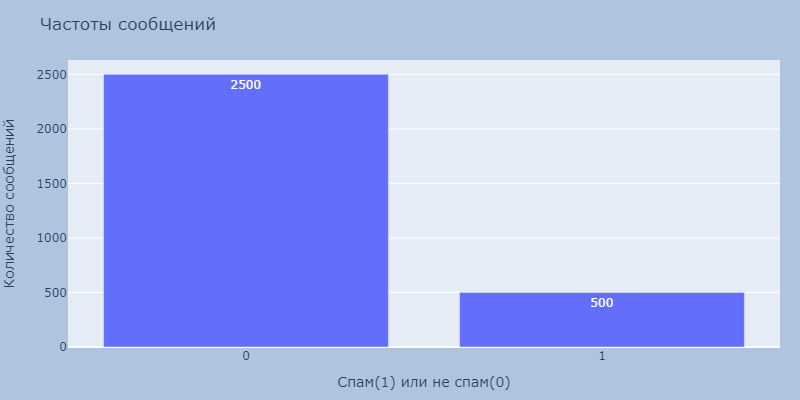

In [4]:
# визуализируйте результат: 
fig = px.bar(data['label'].astype('str').value_counts(), height=400, width=800, text_auto=True,
    title='Частоты сообщений',
    labels={'label':'Спам(1) или не спам(0)', 'value':'Количество сообщений'}
)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    showlegend=False
)

fig.show('png')

## Задание 2 (2 балла)

Вам необходимо предобработать ваши данные и перевести их в векторный вид. Подгрузим необходимый модуль:

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import model_selection
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn import metrics
import plotly.graph_objects as go

Замените в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [6]:
data['email'] = data['email'].str.replace('^/s*$', ' ', regex=True)
data['label'] = data['label'].replace('^/s*$', ' ', regex=True)
data['email'] = data['email'].replace(' ', np.nan)
data['label'] = data['label'].replace(' ', np.nan)

data.dropna(inplace=True)

Переводим данные в векторный вид:

In [7]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data["email"])

Определите, сколько теперь признаков в нашем наборе данных:

In [8]:
X.shape[1]

34116

## Задание 3 (2 балла)

Определите целевую переменную и признаки:

In [9]:
y = data['label']
print(X.shape, y.shape)

(2997, 34116) (2997,)


Разделите выборку на обучающую и тестовую, используя стратифицированное разбиение (параметр `stratify` установите в значение вектора ответов y) размер тестовой выборки (`test_size`) возьмите как 0.25, параметр `random_state` определите со значением 42:

In [10]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [11]:
y_test.mean().round(3)

0.165

## Задание 4 (3 балла)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

In [12]:
alpha = 0.01

mn = MultinomialNB(alpha=alpha)
mn.fit(X_train, y_train)

y_test_pred_mn = mn.predict(X_test)

print(f"Accuracy: {round(metrics.accuracy_score(y_test, y_test_pred_mn), 3)}")
print(f"Precision: {round(metrics.precision_score(y_test, y_test_pred_mn), 3)}")

Accuracy: 0.987
Precision: 1.0


In [13]:
cn = ComplementNB(alpha=alpha)
cn.fit(X_train, y_train)

y_test_pred_cn = cn.predict(X_test)

print(f"Accuracy: {round(metrics.accuracy_score(y_test, y_test_pred_cn), 3)}")
print(f"Precision: {round(metrics.precision_score(y_test, y_test_pred_cn), 3)}")

Accuracy: 0.988
Precision: 1.0


Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [14]:
print(f'Результаты MultinominalNB: Accuracy - {round(metrics.accuracy_score(y_test, y_test_pred_mn), 3)}, Precision - {round(metrics.precision_score(y_test, y_test_pred_mn), 3)}, Recall - {round(metrics.recall_score(y_test, y_test_pred_mn), 3)}, F1-score - {round(metrics.f1_score(y_test, y_test_pred_mn), 3)}')
print(f'Результаты ComplementNB: Accuracy - {round(metrics.accuracy_score(y_test, y_test_pred_cn), 3)}, Precision - {round(metrics.precision_score(y_test, y_test_pred_cn), 3)}, Recall - {round(metrics.recall_score(y_test, y_test_pred_cn), 3)}, F1-score - {round(metrics.f1_score(y_test, y_test_pred_mn), 3)}')

Результаты MultinominalNB: Accuracy - 0.987, Precision - 1.0, Recall - 0.919, F1-score - 0.958
Результаты ComplementNB: Accuracy - 0.988, Precision - 1.0, Recall - 0.927, F1-score - 0.958


Нарисуйте ROC-кривую:

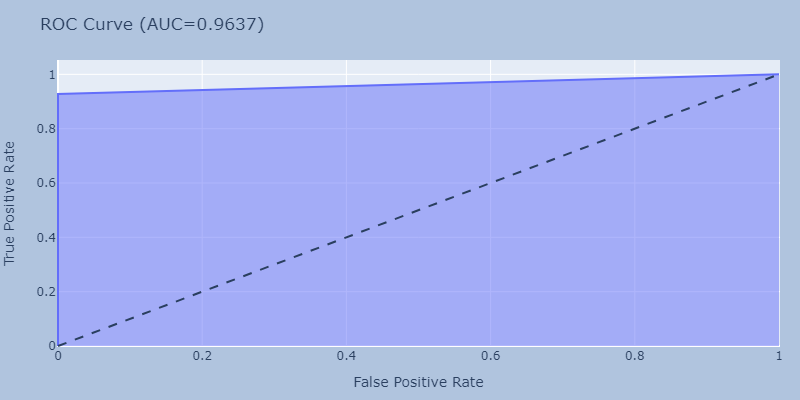

In [15]:
false_positive_rates, true_positive_rates, threshold = metrics.roc_curve(y_test, y_test_pred_cn)

fig = px.area(x=false_positive_rates, y=true_positive_rates, height=400, width=800,
    title=f'ROC Curve (AUC={metrics.auc(false_positive_rates, true_positive_rates):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate')
)
fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    showlegend=False
)

fig.show('png')

## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

In [16]:
alpha_range = np.linspace(0.000001,4,20)
alpha_range_1 = np.linspace(0.000001,0.4,20)
f1_scores = []
f1_scores_1 = []
accuracy = []
accuracy_1 = []
precision = []
precision_1 = []
recall = []
recall_1 = []

for alpha in alpha_range:
    cnb = ComplementNB(alpha=alpha)
    f1 = model_selection.cross_val_score(cnb, X, y, cv=5, scoring='f1')
    acc = model_selection.cross_val_score(cnb, X, y, cv=5, scoring='accuracy')
    pre = model_selection.cross_val_score(cnb, X, y, cv=5, scoring='precision')
    re = model_selection.cross_val_score(cnb, X, y, cv=5, scoring='recall')
    accuracy.append(acc.mean())
    f1_scores.append(f1.mean())
    precision.append(pre.mean())
    recall.append(re.mean())

for alpha in alpha_range_1:
    cnb = ComplementNB(alpha=alpha)
    f1 = model_selection.cross_val_score(cnb, X, y, cv=3, scoring='f1')
    acc = model_selection.cross_val_score(cnb, X, y, cv=3, scoring='accuracy')
    pre = model_selection.cross_val_score(cnb, X, y, cv=5, scoring='precision')
    re = model_selection.cross_val_score(cnb, X, y, cv=5, scoring='recall')
    accuracy_1.append(acc.mean())
    f1_scores_1.append(f1.mean())
    precision_1.append(pre.mean())
    recall_1.append(re.mean())

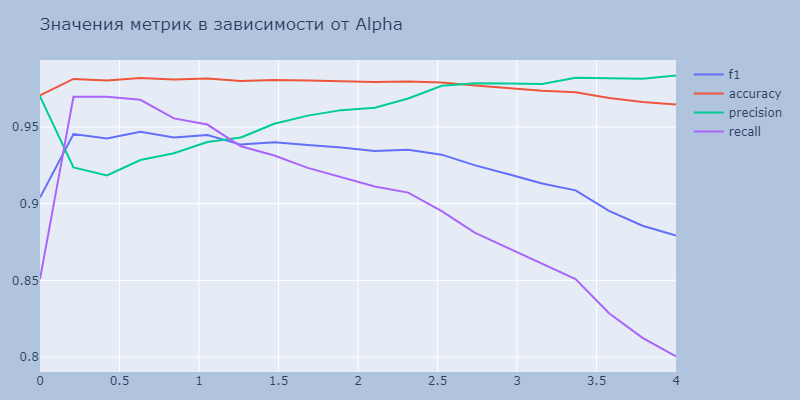

In [17]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=alpha_range, y=f1_scores, mode='lines', name='f1'))
fig.add_trace(go.Scatter(x=alpha_range, y=accuracy, mode='lines', name='accuracy'))
fig.add_trace(go.Scatter(x=alpha_range, y=precision, mode='lines', name='precision'))
fig.add_trace(go.Scatter(x=alpha_range, y=recall, mode='lines', name='recall'))

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    title='Значения метрик в зависимости от Alpha',
    height=400, width=800
)

fig.show('png')

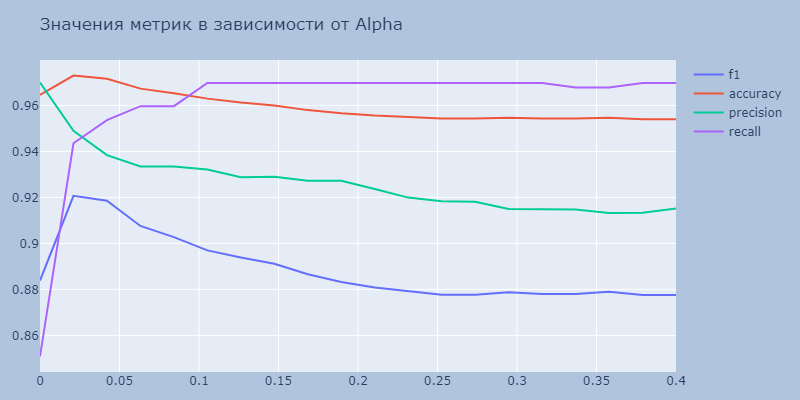

In [18]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=alpha_range_1, y=f1_scores_1, mode='lines', name='f1'))
fig.add_trace(go.Scatter(x=alpha_range_1, y=accuracy_1, mode='lines', name='accuracy'))
fig.add_trace(go.Scatter(x=alpha_range_1, y=precision_1, mode='lines', name='precision'))
fig.add_trace(go.Scatter(x=alpha_range_1, y=recall_1, mode='lines', name='recall'))

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    title='Значения метрик в зависимости от Alpha',
    height=400, width=800
)

fig.show('png')

Наилучшими значениями альфа получились 0.2 и 1.2, в этих точках recall ещё не успела сильно упасть, а precision уже выросла. С увеличением параметра альфа уменьшается количество ложноположительных срабатываний, соответственно метрика precision растёт - модель более точно находит "спам", не отправляя в спам нормальные письма, но также уменьшается способность модели найти "спам", метрика recall уменьшается - увеличивается количество ложноотрицательных сраюатываний.

In [19]:
alpha = 0.2
cn = ComplementNB(alpha=alpha)
cn.fit(X_train, y_train)

y_test_pred_cn = cn.predict(X_test)

print(f"Accuracy: {round(metrics.accuracy_score(y_test, y_test_pred_cn), 4)}")
print(f"Precision: {round(metrics.precision_score(y_test, y_test_pred_cn), 4)}")
print(f"Recall: {round(metrics.recall_score(y_test, y_test_pred_cn), 4)}")

Accuracy: 0.9947
Precision: 0.9918
Recall: 0.9758


In [20]:
alpha = 1.2
cn = ComplementNB(alpha=alpha)
cn.fit(X_train, y_train)

y_test_pred_cn = cn.predict(X_test)

print(f"Accuracy: {round(metrics.accuracy_score(y_test, y_test_pred_cn), 4)}")
print(f"Precision: {round(metrics.precision_score(y_test, y_test_pred_cn), 4)}")
print(f"Recall: {round(metrics.recall_score(y_test, y_test_pred_cn), 4)}")

Accuracy: 0.992
Precision: 0.9917
Recall: 0.9597


Precision почти одинаоквы, recall выше у модели с параметром альфа 0,2, соответственно в ней больше охват всех писем со спамом. Безусловно качество классификации зависит от параметра альфа.